In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utils import load_series_dfs

In [2]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johan\Documents\FH_Master\data", filename="final_learning_dfs.pkl")
series_dfs['FL_00024702.PLAN.MengeHH'].columns

Index(['consumption', 'hour', 'weekday', 'month', 'is_weekend', 'w_tl', 'w_rf',
       'w_ff', 'w_ffx', 'w_cglo', 'w_so_h', 'w_rr', 'w_rrm', 'w_tb10',
       'w_tb20', 'CEGH_WAP', 'THE_WAP'],
      dtype='object')

In [3]:
def prepare_consumption(df):
    s = df['consumption'].copy()
    s = s[~s.index.duplicated(keep='first')].sort_index()
    s = s.resample('h').interpolate().asfreq('h')
    z = (s - s.mean()) / (s.std() + 1e-9)
    return z

Z = {k: prepare_consumption(v) for k,v in series_dfs.items()}

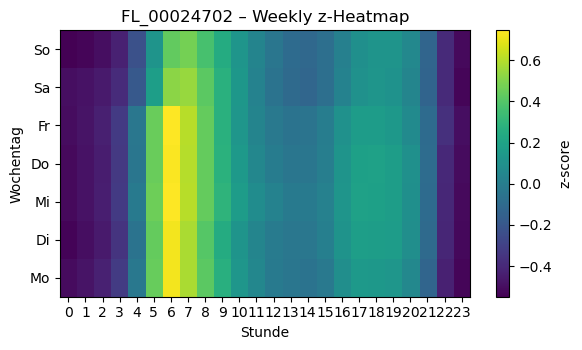

In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def weekly_heatmap(z, title="Weekly profile heatmap"):
    g = z.groupby([z.index.weekday, z.index.hour]).mean().unstack()
    plt.figure(figsize=(6,3.6))
    plt.imshow(g.values, aspect='auto', origin='lower')
    plt.yticks(ticks=range(7), labels=['Mo','Di','Mi','Do','Fr','Sa','So'])
    plt.xticks(ticks=range(24), labels=range(24))
    plt.colorbar(label='z-score')
    plt.title(title); plt.xlabel('Stunde'); plt.ylabel('Wochentag'); plt.tight_layout()

# Beispiel:
weekly_heatmap(Z['FL_00024702.PLAN.MengeHH'], "FL_00024702 – Weekly z-Heatmap")

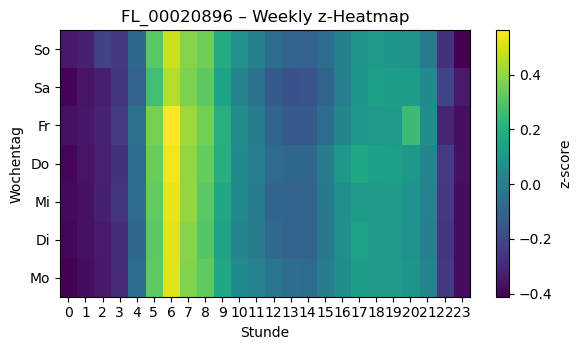

In [13]:
weekly_heatmap(Z['FL_00020896.PLAN.MengeHH'], "FL_00020896 – Weekly z-Heatmap")

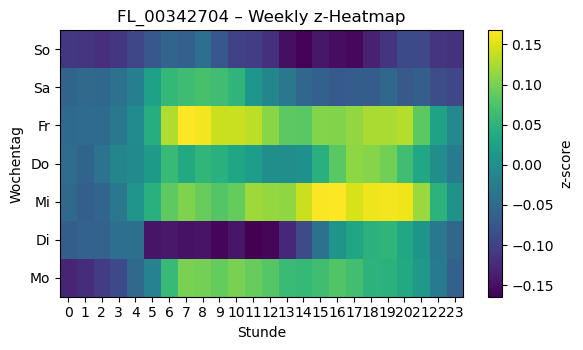

In [14]:
weekly_heatmap(Z['FL_00342704.PLAN.MengeGA'], "FL_00342704 – Weekly z-Heatmap")

In [6]:
from scipy.signal import correlate
from numpy.fft import rfft

def daily_profile(z):
    # Mittel pro Stunde (0..23)
    return z.groupby(z.index.hour).mean().to_numpy()  # (24,)

def weekly_profile(z):
    # Mittel je Wochentag-Stunde (7*24)
    g = z.groupby([z.index.weekday, z.index.hour]).mean().unstack().to_numpy().ravel()
    return g  # (168,)

def acf_features(z, lags=48*7):
    x = z.fillna(0).to_numpy()
    x = x - x.mean()
    c = correlate(x, x, mode='full')
    c = c[c.size//2: c.size//2 + lags + 1]
    c = c / (c[0] + 1e-9)
    # Nimm gezielt ACF bei 24h, 48h, 72h, 168h
    idx = [24, 48, 72, 168]
    feats = [c[i] if i < len(c) else 0.0 for i in idx]
    return np.array(feats, dtype=float)  # (4,)

def fourier_feats(z, k=10):
    x = z.fillna(0).to_numpy()
    mag = np.abs(rfft(x))
    # ignoriere DC, nimm Top-k Frequenzen (ohne DC)
    mag[0] = 0.0
    topk = np.sort(mag)[-k:]
    # energie-normieren
    topk = topk / (np.linalg.norm(topk) + 1e-9)
    return topk   # (k,)

def build_embedding(z):
    d = daily_profile(z)                    # 24
    w = weekly_profile(z)                   # 168
    a = acf_features(z)                     # 4
    f = fourier_feats(z, k=10)              # 10
    # z-Score je Block, damit keiner dominiert
    def znorm(v): return (v - v.mean()) / (v.std() + 1e-9)
    emb = np.concatenate([znorm(d), znorm(w), a, f])  # 24+168+4+10 = 206
    return emb

EMB = {k: build_embedding(z) for k,z in Z.items()}
keys = list(EMB.keys())
X = np.vstack([EMB[k] for k in keys])  # (n_series, 206)

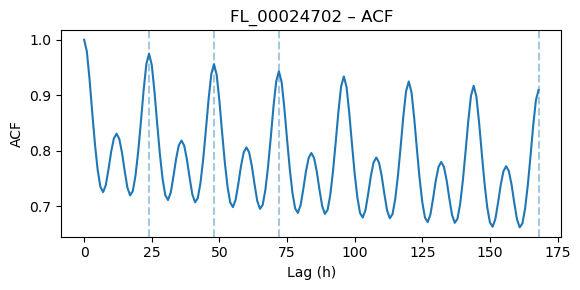

In [15]:
from scipy.signal import correlate

def acf_plot(z, max_lag=24*7, marks=[24,48,72,168], title="ACF"):
    x = z.fillna(0).to_numpy()
    x = x - x.mean()
    c = correlate(x, x, mode='full')
    c = c[c.size//2: c.size//2 + max_lag + 1]
    acf = c / (c[0] + 1e-9)
    plt.figure(figsize=(6,3))
    plt.plot(acf); plt.title(title); plt.xlabel("Lag (h)"); plt.ylabel("ACF")
    for m in marks:
        if m <= max_lag: plt.axvline(m, ls='--', alpha=0.4)
    plt.tight_layout()

acf_plot(Z['FL_00024702.PLAN.MengeHH'], title="FL_00024702 – ACF")

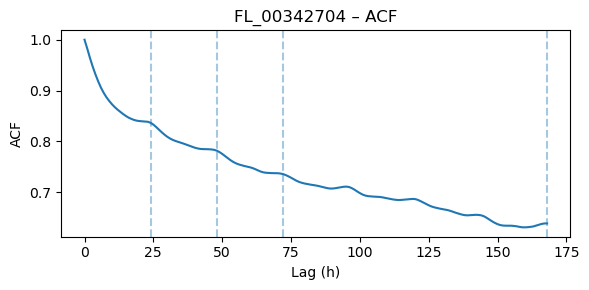

In [17]:
acf_plot(Z['FL_00342704.PLAN.MengeGA'], title="FL_00342704 – ACF")

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize

# Cosine-ähnlich: erst L2-normalisieren, dann KMeans (Euclid ≈ Cosine)
Xn = normalize(X)

best = {'k': None, 'sil': -1, 'db': np.inf, 'labels': None, 'model': None}
for k in range(2, min(12, len(keys))):  # 2..11
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    lab = km.fit_predict(Xn)
    sil = silhouette_score(Xn, lab)
    db  = davies_bouldin_score(Xn, lab)
    # simple score: maximize silhouette, break ties with low DB
    if sil > best['sil'] or (np.isclose(sil, best['sil']) and db < best['db']):
        best = {'k': k, 'sil': sil, 'db': db, 'labels': lab, 'model': km}

labels = best['labels']
k = best['k']
clusters = {c: [keys[i] for i in range(len(keys)) if labels[i]==c] for c in range(k)}

C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\johan\miniconda3\envs\ersatzwerte_project\lib\sit

In [9]:
clusters

{0: ['FL_00024702.PLAN.MengeHH',
  'FL_00024730.PLAN.MengeHH',
  'FL_00352243.PLAN.MengeHH',
  'FL_00352244.PLAN.MengeKW',
  'FL_00024731.PLAN.MengeHH',
  'FL_00024735.PLAN.MengeHH',
  'FL_00024667.PLAN.MengeHH',
  'FL_00352218.PLAN.MengeHH',
  'FL_00025240.PLAN.MengeHH',
  'FL_00025241.PLAN.MengeHH',
  'FL_00020896.PLAN.MengeHH',
  'FL_00342704.PLAN.MengeGA',
  'FL_00352054.PLAN.MengeHH',
  'FL_00352254.PLAN.MengeHH',
  'FL_00352244.PLAN.MengeHH',
  'FL_00342704.PLAN.MengeHH',
  'CV_00003083.PLAN.Menge',
  'CV_00003181.PLAN.Menge',
  'CV_00003192.PLAN.Menge',
  'CV_00003191.PLAN.Menge',
  'CV_00003183.PLAN.Menge',
  'CV_00001876.PLAN.Menge',
  'CV_00003094.PLAN.Menge',
  'CV_00003089.PLAN.Menge',
  'CV_00007270.PLAN.Menge',
  'CV_00007300.PLAN.Menge',
  'KN_00000069.PLAN.Menge',
  'KN_00000067.PLAN.Menge',
  'CV_00007809.PLAN.Menge',
  'FL_00352191.PLAN.MengeHH',
  'FL_00352189.PLAN.MengeHH',
  'KN_00001886.PLAN.Menge',
  'KN_00001602.PLAN.Menge',
  'FL_00352430.PLAN.MengeHH',
  'FL_0

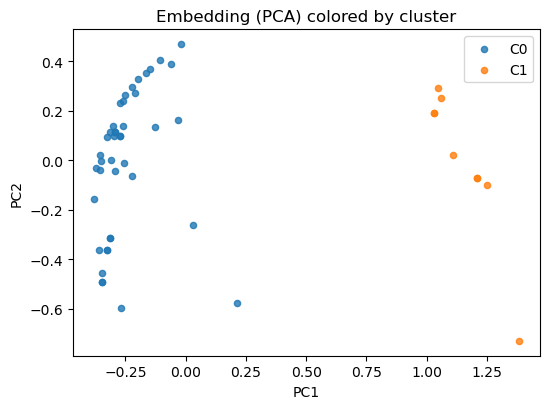

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def scatter_2d(Xn, labels, title="Embedding (PCA) colored by cluster"):
    pca = PCA(n_components=2, random_state=0).fit(Xn)
    XY = pca.transform(Xn)
    plt.figure(figsize=(5.6,4.2))
    for c in np.unique(labels):
        sel = labels==c
        plt.scatter(XY[sel,0], XY[sel,1], s=20, label=f"C{c}", alpha=0.8)
    plt.legend(); plt.title(title); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.tight_layout()

scatter_2d(Xn, labels)

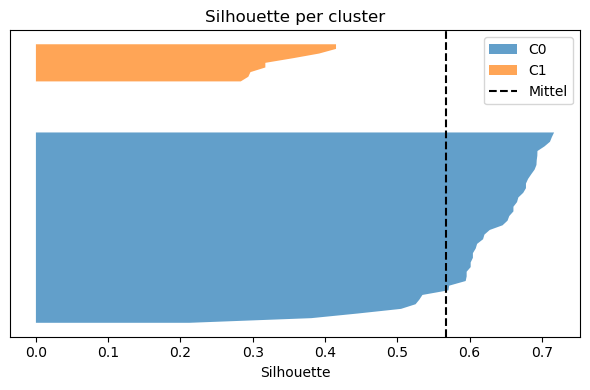

In [19]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

def silhouette_plot(Xn, labels, title="Silhouette per cluster"):
    sil = silhouette_samples(Xn, labels)
    y_low = 10
    plt.figure(figsize=(6,4))
    for c in np.unique(labels):
        c_sil = np.sort(sil[labels==c])
        y_high = y_low + len(c_sil)
        plt.fill_betweenx(np.arange(y_low, y_high), 0, c_sil, alpha=0.7, label=f"C{c}")
        y_low = y_high + 10
    plt.axvline(np.mean(sil), color='k', ls='--', label='Mittel')
    plt.xlabel("Silhouette"); plt.yticks([]); plt.title(title); plt.legend(); plt.tight_layout()

silhouette_plot(Xn, labels)

In [20]:
def k_selection_plot(ks, silhouettes, db_scores):
    fig, ax1 = plt.subplots(figsize=(6,3))
    ax1.plot(ks, silhouettes, marker='o'); ax1.set_xlabel('k'); ax1.set_ylabel('Silhouette')
    ax2 = ax1.twinx()
    ax2.plot(ks, db_scores, marker='s', ls='--'); ax2.set_ylabel('Davies–Bouldin')
    plt.title("k-Selection"); plt.tight_layout()

k_selection_plot(list_of_k, list_of_sil, list_of_db)

NameError: name 'list_of_k' is not defined

In [10]:
from sklearn.metrics.pairwise import cosine_distances

def cluster_medoid(idxs):
    D = cosine_distances(Xn[idxs], Xn[idxs])
    midx = idxs[D.mean(axis=1).argmin()]
    return midx

cluster_medoids = {}
for c, members in clusters.items():
    idxs = [keys.index(m) for m in members]
    mid = cluster_medoid(idxs)
    cluster_medoids[c] = keys[mid]

In [11]:
cluster_medoids

{0: 'FL_00352243.PLAN.MengeHH', 1: 'FL_00352244.PLAN.MengeGA'}

C:\Users\johan\AppData\Local\Temp\ipykernel_37756\3506409828.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels_order, showfliers=True)


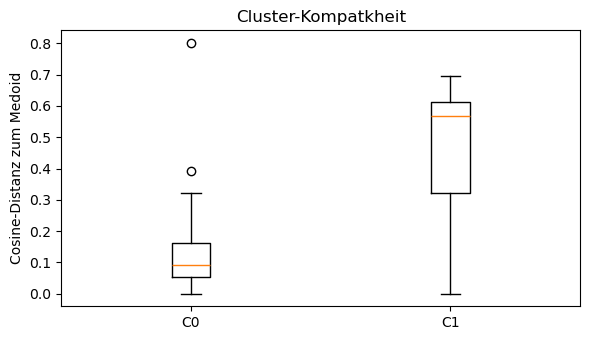

In [21]:
from sklearn.metrics.pairwise import cosine_distances

def dist_to_medoid_plots(Xn, clusters, cluster_medoids):
    fig, ax = plt.subplots(figsize=(6,3.5))
    data = []
    labels_order = []
    for c, members in clusters.items():
        idxs = [keys.index(m) for m in members]
        mid_key = cluster_medoids[c]
        midx = keys.index(mid_key)
        d = cosine_distances(Xn[idxs], Xn[midx:midx+1]).ravel()
        data.append(d); labels_order.append(f"C{c}")
    ax.boxplot(data, labels=labels_order, showfliers=True)
    ax.set_ylabel("Cosine-Distanz zum Medoid"); ax.set_title("Cluster-Kompatkheit"); plt.tight_layout()

dist_to_medoid_plots(Xn, clusters, cluster_medoids)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

# --- Daten vorbereiten ---
# Deine series_dfs ist ein dict mit DataFrames
# Wir extrahieren die Spalte 'consumption' als Zeitreihen
time_series_list = []
names = []

for key, df in series_dfs.items():
    ts = df['consumption'].values
    ts = (ts - ts.mean()) / ts.std()  # z-Score Normalisierung
    time_series_list.append(ts)
    names.append(key)

# In tslearn-Format bringen
X = to_time_series_dataset(time_series_list)

# --- Clustering mit DTW ---
n_clusters = 4  # Clusteranzahl, nach Bedarf anpassen
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(X)

# --- Ergebnisse plotten ---
for cluster_id in range(n_clusters):
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {cluster_id}")
    for i, ts in enumerate(X):
        if labels[i] == cluster_id:
            plt.plot(ts.ravel(), alpha=0.3)  # alle Serien im Cluster
    plt.plot(model.cluster_centers_[cluster_id].ravel(), color="red", linewidth=2)  # Cluster-Zentrum
    plt.show()

MemoryError: Unable to allocate 9.22 GiB for an array with shape (35178, 35178) and data type float64

C:\Users\johan\AppData\Local\Temp\ipykernel_37756\2431806840.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\2431806840.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\2431806840.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\2431806840.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\2431806840.py:8: FutureWarning: 'H' is deprecated and will be removed in a future 

Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.2s


251.802 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


169.126 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


168.971 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


168.971 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.9s


253.663 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


160.119 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


160.119 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


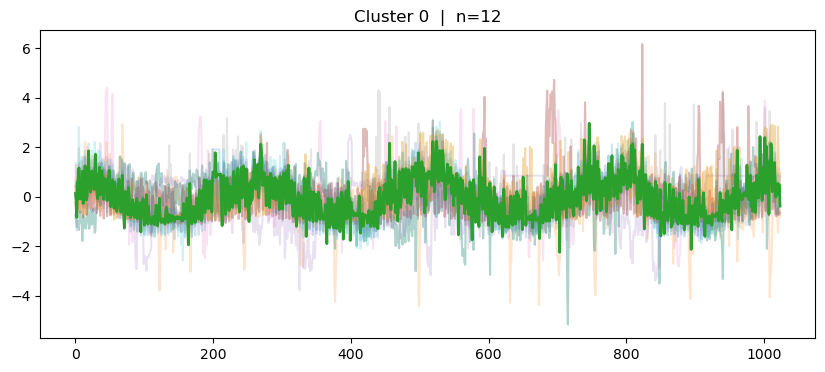

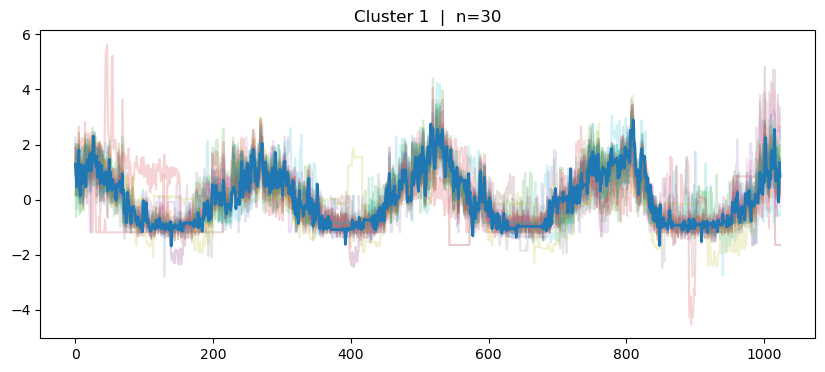

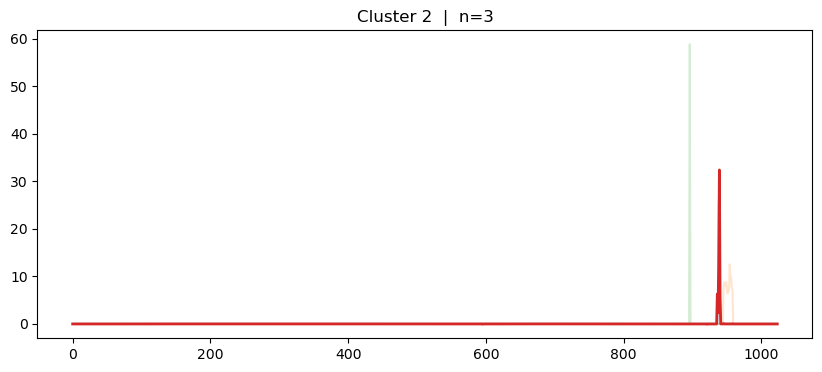

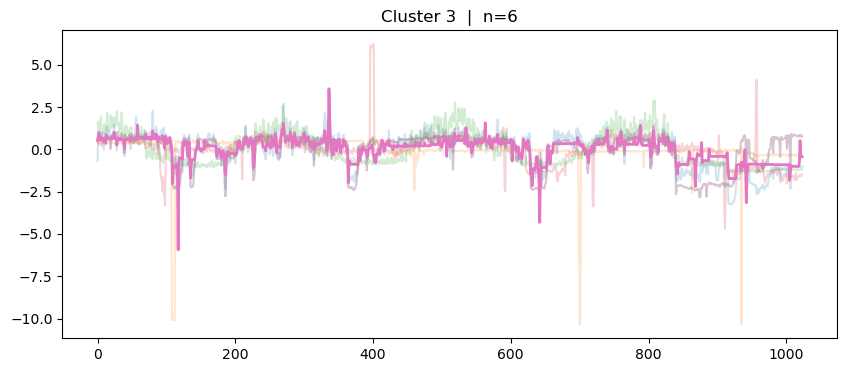

In [25]:
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.clustering import TimeSeriesKMeans

names, ts_list = [], []
for key, df in series_dfs.items():
    s = df['consumption'].astype(float).copy()
    # 6h-Downsampling (bewahrt Tages-/Wochenmuster besser als Tagesmittel)
    s6 = s.resample('6H').mean().interpolate(limit=2)
    # z-Score pro Serie
    s6 = (s6 - s6.mean()) / (s6.std() + 1e-8)
    ts_list.append(s6.values.astype('float32'))
    names.append(key)

# --- 2) Auf einheitliche Länge bringen (z.B. 1024) ---
#    Tipp: 1024/2048 sind gute Startwerte; 512 ist extrem schnell.
target_len = 1024
# tslearn erwartet (n_ts, len, dim); hier dim=1
max_len = max(len(ts) for ts in ts_list)
# padding auf max_len, dann resample auf target_len
X_pad = np.full((len(ts_list), max_len, 1), np.nan, dtype='float32')
for i, ts in enumerate(ts_list):
    X_pad[i, :len(ts), 0] = ts
# fehlende am Ende mit letzten Wert auffüllen
for i in range(X_pad.shape[0]):
    last = np.nanmax(np.where(~np.isnan(X_pad[i, :, 0]))[0])
    X_pad[i, last+1:, 0] = X_pad[i, last, 0]
# resample auf target_len
X = TimeSeriesResampler(sz=target_len).fit_transform(X_pad)

# --- 3) DTW-KMeans mit Band-Constraint & kleinem Barycenter ---
n_clusters = 4
model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 64},  # begrenzt Pfadabweichung
    max_iter=20,
    max_iter_barycenter=5,                      # sparsam mit DBA
    n_init=2,
    random_state=0,
    verbose=True
)
labels = model.fit_predict(X)

# --- 4) Schnelle Sichtprüfung: je Cluster einige Serien & das Zentrum ---
import matplotlib.pyplot as plt

for c in range(n_clusters):
    idx = np.where(labels == c)[0]
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {c}  |  n={len(idx)}")
    # bis zu 30 Kurven leicht transparent
    for i in idx[:30]:
        plt.plot(X[i, :, 0], alpha=0.2)
    plt.plot(model.cluster_centers_[c].ravel(), linewidth=2)
    plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_37756\56900308.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\56900308.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\56900308.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\56900308.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\56900308.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, p

Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


343.765 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


218.754 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


218.599 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


218.599 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


307.795 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


193.300 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


193.263 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


193.263 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


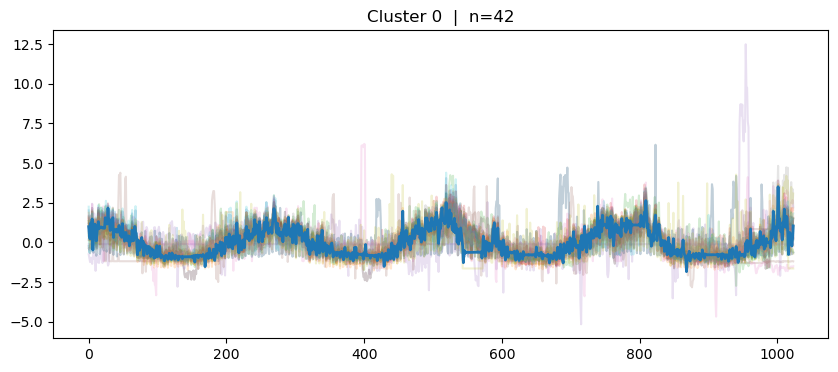

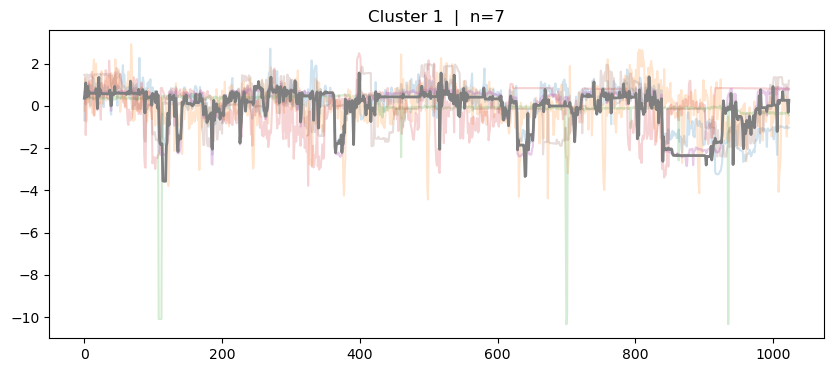

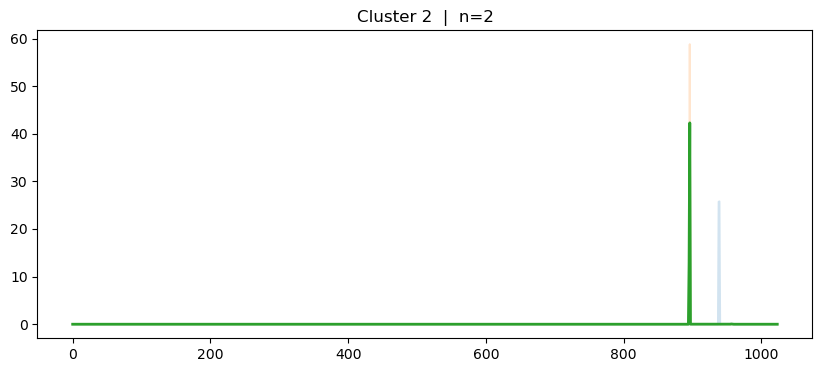

In [26]:
names, ts_list = [], []
for key, df in series_dfs.items():
    s = df['consumption'].astype(float).copy()
    # 6h-Downsampling (bewahrt Tages-/Wochenmuster besser als Tagesmittel)
    s6 = s.resample('6H').mean().interpolate(limit=2)
    # z-Score pro Serie
    s6 = (s6 - s6.mean()) / (s6.std() + 1e-8)
    ts_list.append(s6.values.astype('float32'))
    names.append(key)

# --- 2) Auf einheitliche Länge bringen (z.B. 1024) ---
#    Tipp: 1024/2048 sind gute Startwerte; 512 ist extrem schnell.
target_len = 1024
# tslearn erwartet (n_ts, len, dim); hier dim=1
max_len = max(len(ts) for ts in ts_list)
# padding auf max_len, dann resample auf target_len
X_pad = np.full((len(ts_list), max_len, 1), np.nan, dtype='float32')
for i, ts in enumerate(ts_list):
    X_pad[i, :len(ts), 0] = ts
# fehlende am Ende mit letzten Wert auffüllen
for i in range(X_pad.shape[0]):
    last = np.nanmax(np.where(~np.isnan(X_pad[i, :, 0]))[0])
    X_pad[i, last+1:, 0] = X_pad[i, last, 0]
# resample auf target_len
X = TimeSeriesResampler(sz=target_len).fit_transform(X_pad)

# --- 3) DTW-KMeans mit Band-Constraint & kleinem Barycenter ---
n_clusters = 3
model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 64},  # begrenzt Pfadabweichung
    max_iter=20,
    max_iter_barycenter=5,                      # sparsam mit DBA
    n_init=2,
    random_state=0,
    verbose=True
)
labels = model.fit_predict(X)

# --- 4) Schnelle Sichtprüfung: je Cluster einige Serien & das Zentrum ---
import matplotlib.pyplot as plt

for c in range(n_clusters):
    idx = np.where(labels == c)[0]
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {c}  |  n={len(idx)}")
    # bis zu 30 Kurven leicht transparent
    for i in idx[:30]:
        plt.plot(X[i, :, 0], alpha=0.2)
    plt.plot(model.cluster_centers_[c].ravel(), linewidth=2)
    plt.show()

Init 1


C:\Users\johan\AppData\Local\Temp\ipykernel_37756\1182478465.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\1182478465.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\1182478465.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\1182478465.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\1182478465.py:5: FutureWarning: 'H' is deprecated and will be removed in a future 

515.159 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


262.762 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


260.180 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


243.076 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


230.859 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


226.510 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


226.505 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


226.505 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


368.845 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


257.720 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


257.599 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


257.599 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


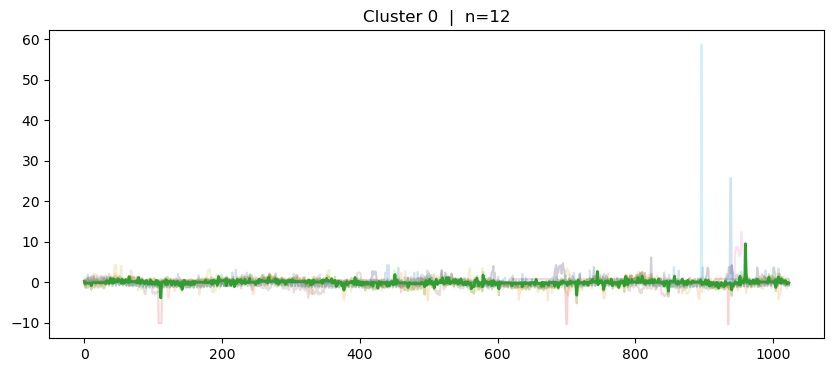

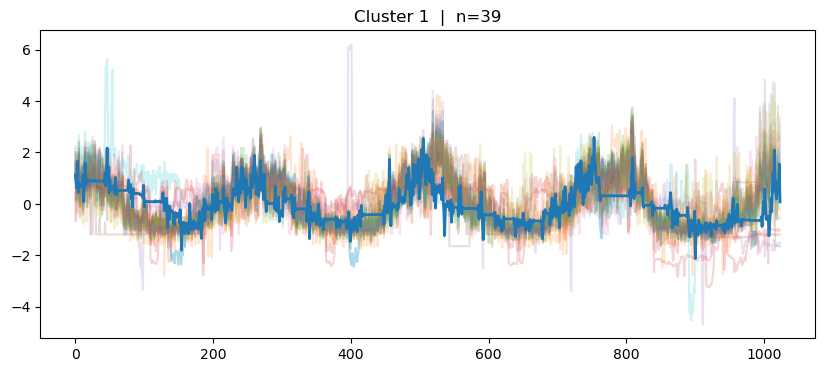

In [27]:
names, ts_list = [], []
for key, df in series_dfs.items():
    s = df['consumption'].astype(float).copy()
    # 6h-Downsampling (bewahrt Tages-/Wochenmuster besser als Tagesmittel)
    s6 = s.resample('6H').mean().interpolate(limit=2)
    # z-Score pro Serie
    s6 = (s6 - s6.mean()) / (s6.std() + 1e-8)
    ts_list.append(s6.values.astype('float32'))
    names.append(key)

# --- 2) Auf einheitliche Länge bringen (z.B. 1024) ---
#    Tipp: 1024/2048 sind gute Startwerte; 512 ist extrem schnell.
target_len = 1024
# tslearn erwartet (n_ts, len, dim); hier dim=1
max_len = max(len(ts) for ts in ts_list)
# padding auf max_len, dann resample auf target_len
X_pad = np.full((len(ts_list), max_len, 1), np.nan, dtype='float32')
for i, ts in enumerate(ts_list):
    X_pad[i, :len(ts), 0] = ts
# fehlende am Ende mit letzten Wert auffüllen
for i in range(X_pad.shape[0]):
    last = np.nanmax(np.where(~np.isnan(X_pad[i, :, 0]))[0])
    X_pad[i, last+1:, 0] = X_pad[i, last, 0]
# resample auf target_len
X = TimeSeriesResampler(sz=target_len).fit_transform(X_pad)

# --- 3) DTW-KMeans mit Band-Constraint & kleinem Barycenter ---
n_clusters = 2
model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 64},  # begrenzt Pfadabweichung
    max_iter=20,
    max_iter_barycenter=5,                      # sparsam mit DBA
    n_init=2,
    random_state=0,
    verbose=True
)
labels = model.fit_predict(X)

# --- 4) Schnelle Sichtprüfung: je Cluster einige Serien & das Zentrum ---
import matplotlib.pyplot as plt

for c in range(n_clusters):
    idx = np.where(labels == c)[0]
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {c}  |  n={len(idx)}")
    # bis zu 30 Kurven leicht transparent
    for i in idx[:30]:
        plt.plot(X[i, :, 0], alpha=0.2)
    plt.plot(model.cluster_centers_[c].ravel(), linewidth=2)
    plt.show()

Init 1


C:\Users\johan\AppData\Local\Temp\ipykernel_37756\4006085851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\4006085851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\4006085851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\4006085851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_37756\4006085851.py:5: FutureWarning: 'H' is deprecated and will be removed in a future 

234.030 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


149.978 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


148.116 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


148.116 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


148.116 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


199.575 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


135.419 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


135.419 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.0s


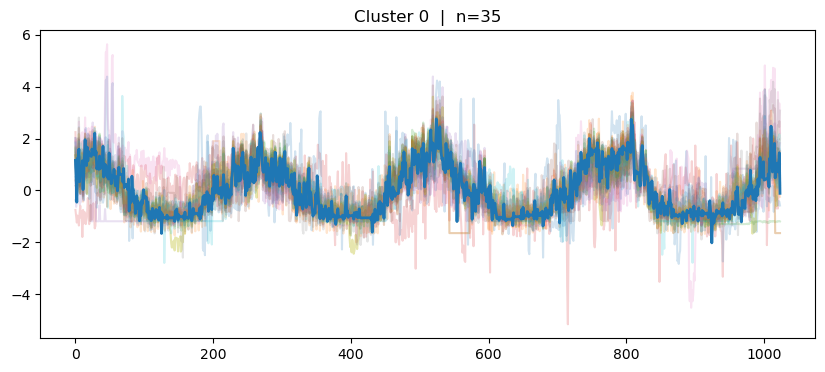

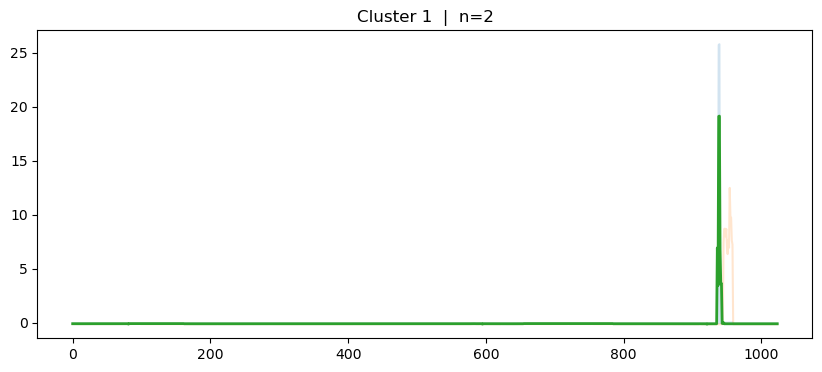

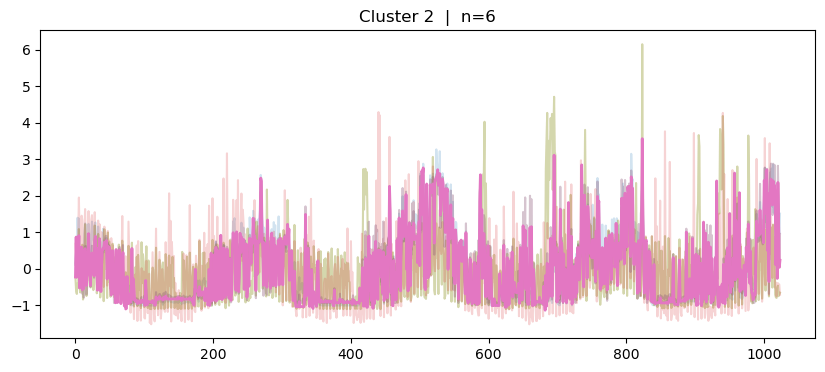

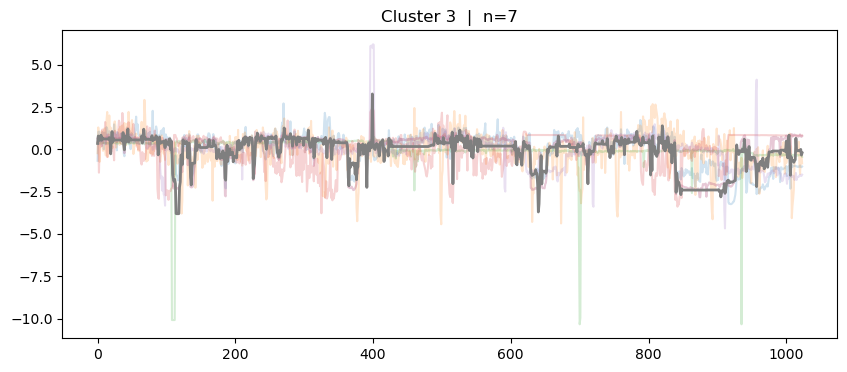

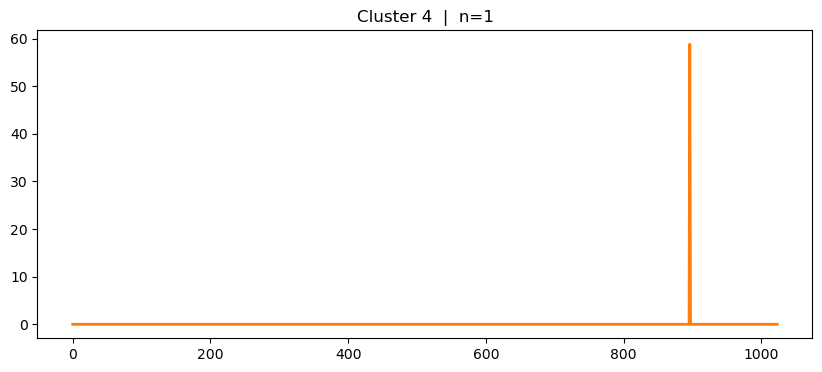

In [28]:
names, ts_list = [], []
for key, df in series_dfs.items():
    s = df['consumption'].astype(float).copy()
    # 6h-Downsampling (bewahrt Tages-/Wochenmuster besser als Tagesmittel)
    s6 = s.resample('6H').mean().interpolate(limit=2)
    # z-Score pro Serie
    s6 = (s6 - s6.mean()) / (s6.std() + 1e-8)
    ts_list.append(s6.values.astype('float32'))
    names.append(key)

# --- 2) Auf einheitliche Länge bringen (z.B. 1024) ---
#    Tipp: 1024/2048 sind gute Startwerte; 512 ist extrem schnell.
target_len = 1024
# tslearn erwartet (n_ts, len, dim); hier dim=1
max_len = max(len(ts) for ts in ts_list)
# padding auf max_len, dann resample auf target_len
X_pad = np.full((len(ts_list), max_len, 1), np.nan, dtype='float32')
for i, ts in enumerate(ts_list):
    X_pad[i, :len(ts), 0] = ts
# fehlende am Ende mit letzten Wert auffüllen
for i in range(X_pad.shape[0]):
    last = np.nanmax(np.where(~np.isnan(X_pad[i, :, 0]))[0])
    X_pad[i, last+1:, 0] = X_pad[i, last, 0]
# resample auf target_len
X = TimeSeriesResampler(sz=target_len).fit_transform(X_pad)

# --- 3) DTW-KMeans mit Band-Constraint & kleinem Barycenter ---
n_clusters = 5
model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",
    metric_params={"sakoe_chiba_radius": 64},  # begrenzt Pfadabweichung
    max_iter=20,
    max_iter_barycenter=5,                      # sparsam mit DBA
    n_init=2,
    random_state=0,
    verbose=True
)
labels = model.fit_predict(X)

# --- 4) Schnelle Sichtprüfung: je Cluster einige Serien & das Zentrum ---
import matplotlib.pyplot as plt

for c in range(n_clusters):
    idx = np.where(labels == c)[0]
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {c}  |  n={len(idx)}")
    # bis zu 30 Kurven leicht transparent
    for i in idx[:30]:
        plt.plot(X[i, :, 0], alpha=0.2)
    plt.plot(model.cluster_centers_[c].ravel(), linewidth=2)
    plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_8028\1761243330.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_8028\1761243330.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_8028\1761243330.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_8028\1761243330.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s6 = s.resample('6H').mean().interpolate(limit=2)
C:\Users\johan\AppData\Local\Temp\ipykernel_8028\1761243330.py:15: FutureWarning: 'H' is deprecated and will be removed in a future 

   silhouette  inertia  ari_vs_prev_k
2       0.350  226.505            NaN
3       0.540  177.977          0.250
4       0.200  151.340          0.230
5       0.229  135.419          0.461


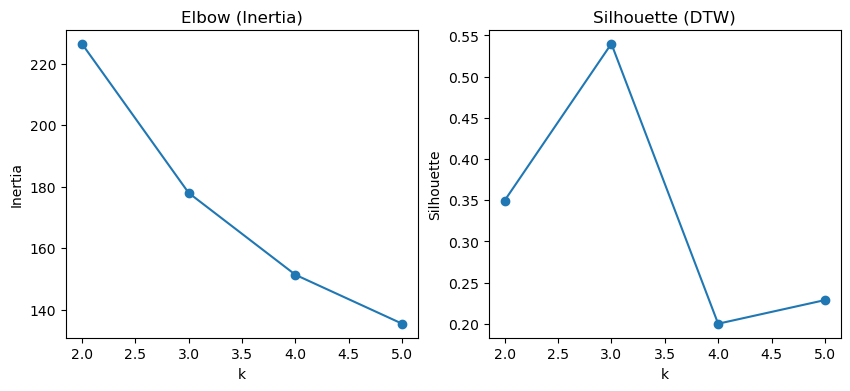


Beste Silhouette bei k=3
   cluster  n_series                medoid_key  \
0        0        48    CV_00003432.PLAN.Menge   
1        1         1    KN_00000067.PLAN.Menge   
2        2         2  FL_00024360.PLAN.MengeGA   

                                           neighbors  
0  [CV_00003432.PLAN.Menge, FL_00352054.PLAN.Meng...  
1                           [KN_00000067.PLAN.Menge]  
2  [FL_00024360.PLAN.MengeGA, FL_00352254.PLAN.Me...  


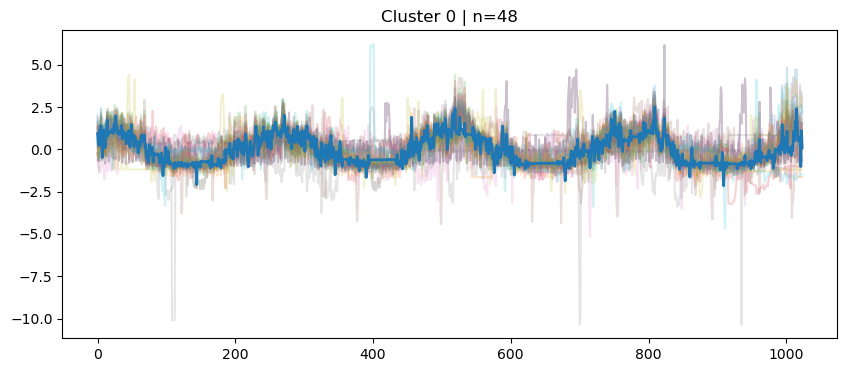

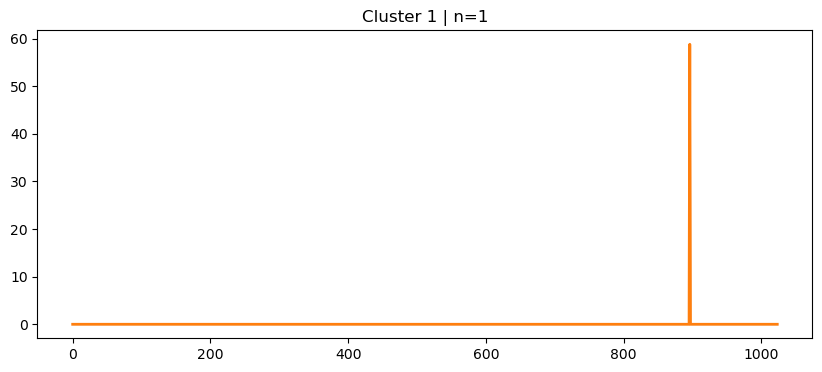

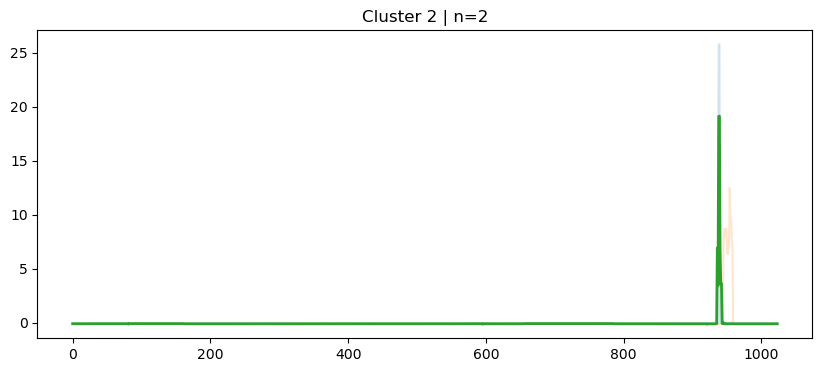

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler

from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score, adjusted_rand_score

# --- 1) Daten sammeln & normalisieren ---
names, ts_list = [], []
for key, df in series_dfs.items():
    s = df['consumption'].astype(float).copy()
    # 6h-Downsampling (bewahrt Tages-/Wochenmuster besser als Tagesmittel)
    s6 = s.resample('6h').mean().interpolate(limit=2)
    # z-Score pro Serie
    s6 = (s6 - s6.mean()) / (s6.std() + 1e-8)
    ts_list.append(s6.values.astype('float32'))
    names.append(key)

# --- 2) Auf einheitliche Länge bringen (z.B. 1024) ---
#    Tipp: 1024/2048 sind gute Startwerte; 512 ist extrem schnell.
target_len = 1024
# tslearn erwartet (n_ts, len, dim); hier dim=1
max_len = max(len(ts) for ts in ts_list)
# padding auf max_len, dann resample auf target_len
X_pad = np.full((len(ts_list), max_len, 1), np.nan, dtype='float32')
for i, ts in enumerate(ts_list):
    X_pad[i, :len(ts), 0] = ts
# fehlende am Ende mit letzten Wert auffüllen
for i in range(X_pad.shape[0]):
    last = np.nanmax(np.where(~np.isnan(X_pad[i, :, 0]))[0])
    X_pad[i, last+1:, 0] = X_pad[i, last, 0]
# resample auf target_len
X = TimeSeriesResampler(sz=target_len).fit_transform(X_pad)

# --- 1) Einmalig: DTW-Distanzmatrix (kleines Band für Speed/RAM) ---
radius = 64
D = cdist_dtw(
    X,                            # (n_ts, len, 1)
    global_constraint="sakoe_chiba",
    sakoe_chiba_radius=radius
).astype("float32")

# --- 2) Clustern für k=2..5 und Metriken sammeln ---
k_list = [2,3,4,5]
results = {}
prev_labels = None
for k in k_list:
    model = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        metric_params={"sakoe_chiba_radius": radius},
        max_iter=20,
        max_iter_barycenter=5,
        n_init=3,
        random_state=0,
        verbose=False
    )
    labels = model.fit_predict(X)

    # Silhouette auf Basis der vorab berechneten Distanzen
    sil = silhouette_score(D, labels, metric="precomputed")
    # Inertia (modellintern, DTW-basiert)
    inertia = model.inertia_

    # Stabilität ggü. vorherigem k via ARI
    ari = adjusted_rand_score(prev_labels, labels) if prev_labels is not None else np.nan
    prev_labels = labels.copy()

    results[k] = {
        "model": model,
        "labels": labels,
        "silhouette": sil,
        "inertia": inertia,
        "ari_vs_prev_k": ari
    }

# Tabelle
df_eval = pd.DataFrame({
    k: { "silhouette": r["silhouette"], "inertia": r["inertia"], "ari_vs_prev_k": r["ari_vs_prev_k"] }
    for k, r in results.items()
}).T.sort_index()
print(df_eval.round(3))

# --- 3) Elbow & Silhouette plotten ---
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(df_eval.index, df_eval["inertia"], marker="o"); ax[0].set_title("Elbow (Inertia)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(df_eval.index, df_eval["silhouette"], marker="o"); ax[1].set_title("Silhouette (DTW)"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.show()

# --- 4) Medoid je Cluster + nächste Nachbarn (repräsentative Reihen) ---
def medoid_and_neighbors(D, idxs, topn=5):
    # Medoid: Element mit minimaler Summendistanz im Cluster
    sub = D[np.ix_(idxs, idxs)]
    m_local = np.argmin(sub.sum(axis=1))
    medoid_idx = idxs[m_local]
    # Nächste Nachbarn innerhalb des Clusters (inkl. Medoid)
    order = np.argsort(D[medoid_idx, idxs])
    nn_local = [idxs[i] for i in order[:topn]]
    return medoid_idx, nn_local

# Nimm z.B. das k mit bester Silhouette
k_best = df_eval["silhouette"].idxmax()
labels = results[k_best]["labels"]
model  = results[k_best]["model"]

print(f"\nBeste Silhouette bei k={k_best:.0f}")

summary_rows = []
for c in range(k_best):
    idxs = np.where(labels == c)[0].tolist()
    med, neigh = medoid_and_neighbors(D, idxs, topn=5)
    summary_rows.append({
        "cluster": c,
        "n_series": len(idxs),
        "medoid_key": names[med],
        "neighbors": [names[i] for i in neigh]
    })

df_summary = pd.DataFrame(summary_rows)
print(df_summary)

# --- 5) Schneller Sichtcheck: Overlays + Zentrum ---
for c in range(k_best):
    idxs = np.where(labels == c)[0]
    plt.figure(figsize=(10,4))
    plt.title(f"Cluster {c} | n={len(idxs)}")
    for i in idxs[:30]:  # 30 zufällige/erste für Lesbarkeit
        plt.plot(X[i,:,0], alpha=0.2)
    plt.plot(model.cluster_centers_[c].ravel(), linewidth=2)
    plt.show()